<a href="https://www.kaggle.com/code/ifeoluwaolonijolu/g-cropdisease-detection?scriptVersionId=223812447" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing important Packages and Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

## Importing other useful packages and libraries 
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import PIL
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Know the data Directories

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ghana-crop-disease/SampleSubmission.csv
/kaggle/input/ghana-crop-disease/Train.csv
/kaggle/input/ghana-crop-disease/Test.csv
/kaggle/input/ghana-crop-disease/images/id_p8dxgn.jpg
/kaggle/input/ghana-crop-disease/images/id_g2syp1.jpg
/kaggle/input/ghana-crop-disease/images/id_zx8php.jpg
/kaggle/input/ghana-crop-disease/images/id_6ne6qc.jpg
/kaggle/input/ghana-crop-disease/images/id_masrex.jpg
/kaggle/input/ghana-crop-disease/images/id_v9lx4u.jpg
/kaggle/input/ghana-crop-disease/images/id_qn4cyl.jpg
/kaggle/input/ghana-crop-disease/images/id_q97obi.jpg
/kaggle/input/ghana-crop-disease/images/id_vxaj7n.jpg
/kaggle/input/ghana-crop-disease/images/id_xh32sn.jpg
/kaggle/input/ghana-crop-disease/images/id_926bx7.jpg
/kaggle/input/ghana-crop-disease/images/id_2wvsgz.jpg
/kaggle/input/ghana-crop-disease/images/id_z5is61.jpg
/kaggle/input/ghana-crop-disease/images/id_ogngxr.jpg
/kaggle/input/ghana-crop-disease/images/id_96sqfc.jpg
/kaggle/input/ghana-crop-disease/images/id_zuhyf1.j

## Loading the dataset

In [3]:
## Loading the data set
train_df = pd.read_csv("/kaggle/input/ghana-crop-disease/Train.csv")
# test set
test_df = pd.read_csv("/kaggle/input/ghana-crop-disease/Test.csv")
# The whole dataset
sample_submission = pd.read_csv("/kaggle/input/ghana-crop-disease/SampleSubmission.csv")

print(train_df.head(3))  # Show first few rows
print(train_df.info())  # Check data structure
print(sample_submission.head(4))
print(sample_submission.info())

        Image_ID  confidence                  class        ymin        xmin  \
0  id_11543h.jpg         1.0  Pepper_Bacterial_Spot  194.649671  328.803454   
1  id_11543h.jpg         1.0  Pepper_Bacterial_Spot  149.632401  256.768914   
2  id_11543h.jpg         1.0  Pepper_Bacterial_Spot  234.046875  327.138158   

         ymax        xmax  
0  208.107730  341.967928  
1  162.910362  266.195724  
2  252.712993  338.876645  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41029 entries, 0 to 41028
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Image_ID    41029 non-null  object 
 1   confidence  41029 non-null  float64
 2   class       41029 non-null  object 
 3   ymin        41029 non-null  float64
 4   xmin        41029 non-null  float64
 5   ymax        41029 non-null  float64
 6   xmax        41029 non-null  float64
dtypes: float64(5), object(2)
memory usage: 2.2+ MB
None
        Image_ID                     

In [4]:
# Check unique disease classes
print("Number of Unique Diseases:", train_df['class'].nunique())
print(train_df['class'].value_counts().head(13))

Number of Unique Diseases: 23
class
Corn_Cercospora_Leaf_Spot    6538
Tomato_Septoria              6483
Tomato_Late_Blight           3918
Corn_Streak                  3180
Tomato_Healthy               2872
Pepper_Septoria              2295
Pepper_Leaf_Mosaic           2113
Tomato_Early_Blight          1946
Pepper_Bacterial_Spot        1943
Corn_Common_Rust             1682
Corn_Healthy                 1571
Pepper_Leaf_Curl             1530
Tomato_Fusarium               882
Name: count, dtype: int64


# Data Preprocessing 
Match Image Paths with Disease Labels

In [5]:
# Define image directory
IMAGE_DIR = "/kaggle/input/ghana-crop-disease/images/"

# Add full image path column for the training data
train_df["image_path"] = IMAGE_DIR + train_df["Image_ID"]

# Add full image path column for the test data
test_df["image_path"] = IMAGE_DIR + test_df["Image_ID"]

# Encode class labels into numerical values for the training data
train_df['label'] = train_df['class'].astype('category').cat.codes

# Check first few rows
print("train_set\n ",train_df.head(2))
print("test_set\n ",test_df.head(2))

train_set
          Image_ID  confidence                  class        ymin        xmin  \
0  id_11543h.jpg         1.0  Pepper_Bacterial_Spot  194.649671  328.803454   
1  id_11543h.jpg         1.0  Pepper_Bacterial_Spot  149.632401  256.768914   

         ymax        xmax                                         image_path  \
0  208.107730  341.967928  /kaggle/input/ghana-crop-disease/images/id_115...   
1  162.910362  266.195724  /kaggle/input/ghana-crop-disease/images/id_115...   

   label  
0      5  
1      5  
test_set
          Image_ID  confidence  class  ymin  xmin  ymax  xmax  \
0  id_128pxx.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
1  id_12jbci.jpg         NaN    NaN   NaN   NaN   NaN   NaN   

                                          image_path  
0  /kaggle/input/ghana-crop-disease/images/id_128...  
1  /kaggle/input/ghana-crop-disease/images/id_12j...  


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


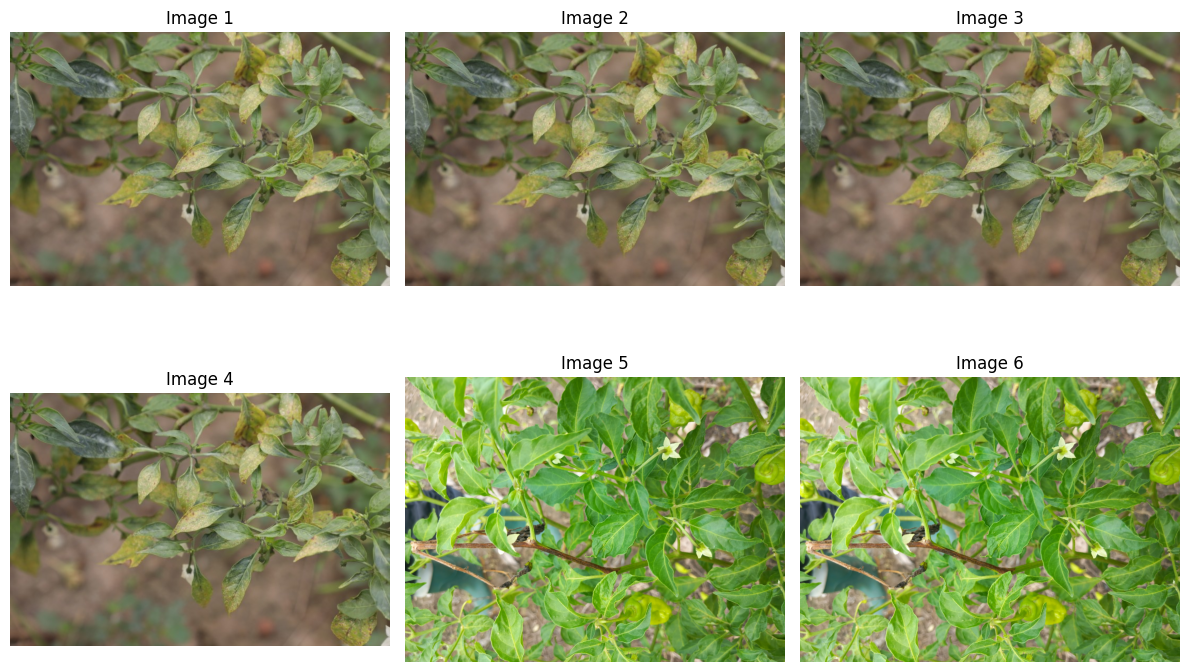

In [6]:

# Create a 2-row, 3-column plot
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # Adjusted figsize

# Loop through the first 6 images
for i in range(6):
    img_path = train_df["image_path"].iloc[i]  # Correct way to access paths
    img = Image.open(img_path)  # Open the image
    
    row, col = divmod(i, 3)  # Convert index to (row, col) for subplot indexing
    axes[row, col].imshow(img)  # Correct indexing for 2D array
    axes[row, col].axis("off")  # Hide axes
    axes[row, col].set_title(f"Image {i+1}")  # Add title

plt.tight_layout()  # Adjust layout
plt.show()



In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  ## 20% of training data for validation
)

# Using train_datagen for both training & validation splits
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df, 
    x_col='image_path',
    y_col='class',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training',  
    shuffle=True
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df, 
    x_col='image_path',
    y_col='class',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # 
    shuffle=False
)


Found 32824 validated image filenames belonging to 23 classes.
Found 8205 validated image filenames belonging to 23 classes.


# Building the CNN

In [8]:
## Initializing a three convolutional layers
model = Sequential([
    #1st convolutional layer (Input layer)
    Input(shape=(150, 150, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    #2nd convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # 3rd convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten
    Flatten(),
    # Full Connection
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    ## Output layer with unique disease classes
    Dense(train_df['label'].nunique(), activation='softmax') 
])


## Compiling the CNN

In [9]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 23)                  │           2,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,831,319 (18.43 MB)

 Trainable params: 4,831,319 (18.43 MB)

 Non-trainable params: 0 (0.00 B)

## Train the CNN model

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1,
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3736s 4s/step - accuracy: 0.2789 - loss: 2.4270 - val_accuracy: 0.4484 - val_loss: 1.7497
Epoch 2/10
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3533s 3s/step - accuracy: 0.4202 - loss: 1.8147 - val_accuracy: 0.4849 - val_loss: 1.5887
Epoch 3/10
 972/1026 ━━━━━━━━━━━━━━━━━━━━ 2:26 3s/step - accuracy: 0.4754 - loss: 1.5954

# Model Evaluation Performance

## Model Accuracy

In [ ]:
plt.figure(figsize=(8, 5))

# Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.show()


## Loss Function plot

In [ ]:
# Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    x_col='image_path',
    target_size=(150, 150),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

# Predict
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
predictions.summary()



In [ ]:
# Convert predictions to labels
label_map = dict((v, k) for k, v in train_generator.class_indices.items())
test_df['Predicted_Label'] = [label_map[i] for i in predicted_classes]

# Save submission
test_df[['Image_id', 'Predicted_Label']].to_csv("submission.csv", index=False)
print("Submission file saved!")